In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import vivarium, vivarium.test_util as vtu
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns
import pandas as pd
import json

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models.cohort_analysis_function as caf

In [3]:
n_simulants = 1500
n_days = 365
t_start = pd.Timestamp('2017-01-01')
t_timestep = 1
with open('../data/processed/p_return.json') as data_file:    
    return_rates = json.load(data_file)

## Simulate the cohort

In [4]:
class HIVCohortFollowUp:
    def __init__(self , return_rates):
        self.reports = {}
        self.return_rates = return_rates
        self.current_database = pd.DataFrame({'visit_date':[] , 'next_visit_date':[] })
    
    @listens_for('initialize_simulants')
    @uses_columns(['state', 'next_visit_date', 'first_visit','follow_up_duration'])
    def initialize(self, event):
        # create the population dataframe
        population = pd.DataFrame(index=event.index)
        population['state'] = 'Out' #Followed, LTFU, Dead,   
        population['next_visit_date'] = pd.NaT
        population['follow_up_duration'] = 0
        
        # Give first visit
        first_visit = np.round(np.random.uniform(0, 365, n_simulants))
        population['first_visit'] = t_start + pd.to_timedelta(first_visit, 'D')
        
        # Give first follow up
        rows = np.random.binomial(1, 0.5, size=len(population))
        population['next_visit_date'] = population['first_visit'] + pd.Timedelta(days=7*4)
        
        population.loc[population['first_visit'] == t_start , 'state'] = 'Followed'
        
        # update the population in the model
        event.population_view.update(population)
        
    @listens_for('time_step')
    @uses_columns(['state', 'first_visit', 'next_visit_date'], 'state == "Out"')
    def new_patients(self, event):
        df = event.population
        df.loc[df['first_visit'] == event.time, 'state'] = 'Followed'
        df.loc[df['first_visit'] == event.time, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        n_new = len(df.loc[df['first_visit'] == event.time])
        self.current_database = self.current_database.append(pd.DataFrame({'visit_date':[event.time]*n_new, 
                                                                          'next_visit_date':df.loc[df['first_visit'] == event.time, 
                                                                                                   'next_visit_date']} , 
                                                             index = df.index[df['first_visit'] == event.time]))
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state', 'next_visit_date'], 'state != "Out"')
    def next_appointment(self, event):
        df = event.population
        df.visit_delay = (event.time - df['next_visit_date'])/ np.timedelta64(1, 'D')
        
        ordered_change_times = sorted(list(map(int , self.return_rates.keys())))
        
        min_chunk = str(ordered_change_times[0])
        chunk_1 = df[df.visit_delay <= float(min_chunk)]
        visit = np.random.binomial(1, self.return_rates[min_chunk], size=len(chunk_1))
        visitors = list(chunk_1.index[visit == 1])
        
        for i in range(1,len(ordered_change_times) - 1):
            chunk = str(ordered_change_times[i])
            chunk_i = df[(df.visit_delay > float(min_chunk)) & (df.visit_delay <= float(chunk))]
            visit = np.random.binomial(1, self.return_rates[chunk], size=len(chunk_i))
            visitors_i = list(chunk_i.index[visit == 1])
            visitors = visitors + visitors_i
            min_chunk = chunk
            
        max_chunk = str(ordered_change_times[len(ordered_change_times) - 1])
        chunk_n = df[df.visit_delay > float(max_chunk)]
        visit = np.random.binomial(1, self.return_rates[max_chunk], size=len(chunk_n))
        visitors_n = list(chunk_n.index[visit == 1])
        visitors = visitors + visitors_n
        
        n_visitors = len(visitors)
        
        df.loc[visitors, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        if n_visitors > 0 :
            self.current_database = self.current_database.append(
                pd.DataFrame({'visit_date':[event.time]*n_visitors,
                              'next_visit_date': df.loc[visitors, 'next_visit_date']} ,
                             index = list(df.loc[visitors].index)))
        
        df.visit_delay = (event.time - df['next_visit_date'])/ np.timedelta64(1, 'D')
        df.loc[df.visit_delay > 90 , 'state'] = 'LTFU'
        df.loc[df.visit_delay <= 90 , 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state'], 'state != "Out"')
    def export_report_datapoint(self, event):
        date = event.time
        self.reports[date] = event.population.state.value_counts()

In [5]:
components = [HIVCohortFollowUp(return_rates)]
vtu.config.simulation_parameters.time_step = 1/365
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

365

In [6]:
print(simulation.population.population.state.value_counts());
print(simulation.population.population.state.value_counts() / len(simulation.population.population));

Followed    1274
LTFU         226
Name: state, dtype: int64
Followed    0.849333
LTFU        0.150667
Name: state, dtype: float64


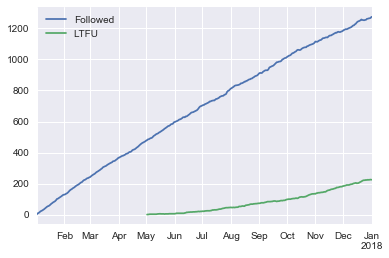

In [7]:
report_out = pd.DataFrame.from_dict(components[0].reports , orient='index')
report_out.plot()

In [8]:
full_database = components[0].current_database.copy()

## Simulate Data Entry

16.0


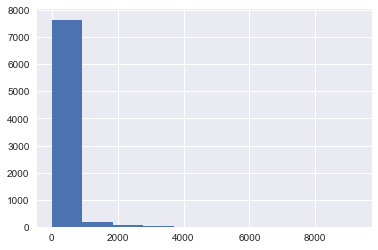

In [9]:
s = np.random.weibull(.4, len(full_database))
u = np.round(s*40)
print(np.median(u))
plt.hist(u , bins=10);

In [10]:
full_database['delta'] = pd.to_timedelta(u , 'days')
full_database['date_entered'] = full_database.visit_date + full_database.delta

In [11]:
full_database['patient_id']= full_database.index

In [12]:
full_database = full_database.reset_index()

In [13]:
full_database['reasonDescEn'] = np.nan
full_database['discDate'] = pd.NaT

In [14]:
d = full_database.groupby('patient_id').apply(caf.get_first_visit_date)

In [15]:
months_reports = {}
for month in ['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', 
              '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'] :
    print(month)
    out = d.groupby(d.patient_id).apply(caf.status_patient, reference_date = month, 
                    analysis_date = month, grace_period = 90)
    months_reports[month] = out.status.value_counts()

2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01


In [16]:
reports = pd.DataFrame.from_dict(months_reports , orient='index')

In [18]:
all_reports = report_out.merge(reports, 'left', left_index = True , right_index=True , suffixes=(' real', ' observed'))

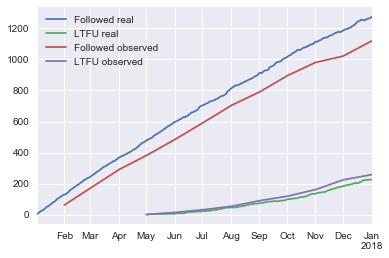

In [19]:
all_reports.interpolate().plot()

In [22]:
23/225

0.10222222222222223